# 3-1_RNN

We will be building and training a basic character-level RNN to classify words. 

A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```
More info: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

![many-to-one](https://i.stack.imgur.com/ionGp.png)

In [1]:
!nvidia-smi

Tue Feb  8 23:33:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preparing the Data

Download the ``data_rnn.zip``file and extract it to the working directory

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -q data.zip

--2022-02-09 09:40:13--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.63.5, 54.230.63.82, 54.230.63.24, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.63.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  2.25MB/s    in 1.2s    

2022-02-09 09:40:16 (2.25 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [2]:
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Irish.txt', 'data/names/Portuguese.txt', 'data/names/French.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/Italian.txt', 'data/names/Korean.txt', 'data/names/Greek.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt']


Name data formatting for training

In [3]:
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [4]:
!head data/names/Polish.txt

Adamczak
Adamczyk
Andrysiak
Auttenberg
Bartosz
Bernard
Bobienski
Bosko
Broż
Brzezicki


In [5]:
import unicodedata

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
for c in unicodedata.normalize('NFD', 'Ślusàrski'):
    print(c, unicodedata.category(c))

S Lu
́ Mn
l Ll
u Ll
s Ll
a Ll
̀ Mn
r Ll
s Ll
k Ll
i Ll


https://docs.python.org/3/library/unicodedata.html#unicodedata.normalize

For example, the character U+00C7 (LATIN CAPITAL LETTER C WITH CEDILLA) can also be expressed as the sequence U+0043 (LATIN CAPITAL LETTER C) U+0327 (COMBINING CEDILLA).

[Unicode categories](https://www.compart.com/en/unicode/category)

In [7]:
print(chr(0x00c7))
print(chr(0x0043))
print(chr(0x0327))
print(chr(0x0043) + chr(0x0327))

Ç
C
̧
Ç


In [8]:
print(chr(0xb098))
print(chr(0x1102))
print(chr(0x1161))
print(chr(0x1102) + chr(0x1161))

나
ᄂ
ᅡ
나


Read files and save as dictionary according to the category

In [38]:
import os

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(all_categories, "\n", n_categories)

['Spanish', 'Vietnamese', 'Irish', 'Portuguese', 'French', 'Russian', 'German', 'English', 'Arabic', 'Polish', 'Dutch', 'Chinese', 'Scottish', 'Italian', 'Korean', 'Greek', 'Czech', 'Japanese'] 
 18


In [10]:
basename = os.path.basename('data/names/English.txt')
print(basename)
print(os.path.splitext(basename))  # ext: 확장자 (extension)

English.txt
('English', '.txt')


Now we have ``category_lines``, a dictionary mapping each category (language) to a list of lines (names).

In [11]:
len(category_lines)

18

In [12]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors

In [13]:
all_letters.index('J')

35

In [46]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    # TO DO
    # create an one-hot-vector with (1, n_letters) size
    # expected output 'tensor' : torch.Tensor with size (1, n_letters)
    # where all values are zero except one
    # hint: tensor[0][index of letter] = 1, others are 0
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    # TO DO
    # (word_count, 1, n_letters)   word_count: len(line)
    # method A: call letterToTensor (multiple times) and stack
    # method B: do what we did in letterToTensor, iterating over line

    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letterToIndex(letter)] = 1

    return tensor

print(letterToTensor('J'))
print(letterToTensor('J').size())
print(lineToTensor('Jones').size())
print(lineToTensor('Jones').size(0))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 57])
torch.Size([5, 1, 57])
5


## Creating the Network

![image.png](https://i.imgur.com/Z2xbySO.png)

Here we define simple RNN cell (without tanh activation).

In [17]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # input: (1, n_letters)
        # hidden: (1, self.hidden_size)
        combined = torch.cat((input, hidden), 1)
        # TODO: compute hidden and output
        # hint: use self.i2h, self.i2o, and self.softmax
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
model = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [18]:
input = letterToTensor('A')  # (1, n_letters)
print(input.shape)

hidden = model.initHidden()

output, next_hidden = model(input, hidden)

print(output.shape)
print(next_hidden.shape)

torch.Size([1, 57])
torch.Size([1, 18])
torch.Size([1, 128])


In [19]:
input = lineToTensor('Albert')
print(input.shape)

hidden = model.initHidden()

output, next_hidden = model(input[0], hidden)
print(output)
print(output.shape)

torch.Size([6, 1, 57])
tensor([[-2.9052, -2.9164, -2.9848, -2.8912, -2.8725, -2.8637, -2.9626, -2.9795,
         -2.8229, -2.8336, -2.9210, -2.8661, -2.8647, -2.8475, -3.0220, -2.8809,
         -2.7912, -2.8337]], grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 18])


In [ ]:
# TO DO
# predict category for name 'Kim'
# 1. create input tensor
# TODO
input = ...  # (3, 1, 57)
print(input.shape)
# 2. initialize hidden state

# 3. iterate over input

print(output)
print(output.shape)

## Training

Randomly select (category, line) pair for training

In [ ]:
print(category_lines)

In [26]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    # TO DO
    # expected output
    # category: string
    # line: string
    # category_tensor: torch.Tensor with shape (1, )
    # line_tensor: (word_count, 1, n_letters)
    # hint: use all_categories and category_lines
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)]) # (1, )
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Pantelakos
category = Arabic / line = Hakimi
category = Greek / line = Koulaxizis
category = Polish / line = Jaskulski
category = Dutch / line = Altena
category = Korean / line = Shon
category = Japanese / line = Etsuko
category = Polish / line = Kosmatka
category = Spanish / line = Roig
category = Vietnamese / line = Ha


In [27]:
category = randomChoice(all_categories)
line = randomChoice(category_lines[category])
category_tensor = torch.tensor([all_categories.index(category)])
line_tensor = lineToTensor(line)
print(category, line, category_tensor)
print(line_tensor)

Spanish Valdez tensor([0])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    

In [28]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir log

In [34]:
import time
import math
from tqdm.autonotebook import tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

n_steps = 100000
lr = 0.005 # If you set this too high, it might explode. If too low, it might not learn
log_dir = 'log/rnn'
print_every = 5000
device = 'cuda'

model = RNN(n_letters, n_hidden, n_categories)
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)


training_start_time = time.time()
writer = SummaryWriter(log_dir)
running_loss = 0

for step in tqdm(range(1, n_steps + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # TO DO

    # 0. move tensors to device
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    # category_tensor, line_tensor = category_tensor.to(device), line_tensor.to(device)
    # 1. make prediction using model and line_tensor
    hidden = model.initHidden().to(device)
    for i in range(line_tensor.size(0)):
        output, hidden = model(line_tensor[i], hidden)
    # 2. compute loss using model prediction and category_tensor
    loss = criterion(output, category_tensor)
    # 3. optimizer step
    loss.backward()
    optimizer.step()
    
    running_loss += loss.detach()

    # Print iter number, loss, name and guess
    if step % print_every == 0:
        print('{} {:.0f}% ({:.0f}s) {:.3f}'.format(
            step, step/n_steps*100, time.time()-training_start_time, running_loss/print_every))
        writer.add_scalar('loss/train', running_loss/print_every, step)
        running_loss = 0

  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (7s) nan
10000 10% (15s) nan
15000 15% (22s) nan
20000 20% (29s) nan
25000 25% (36s) nan
30000 30% (43s) nan
35000 35% (50s) nan
40000 40% (57s) nan
45000 45% (64s) nan
50000 50% (71s) nan
55000 55% (78s) nan
60000 60% (85s) nan
65000 65% (92s) nan
70000 70% (99s) nan
75000 75% (106s) nan
80000 80% (113s) nan
85000 85% (120s) nan
90000 90% (127s) nan
95000 95% (134s) nan
100000 100% (141s) nan


## Evaluation

In [31]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

model.to('cpu')

# Just return an output given a line
def evaluate(line_tensor):
    hidden = model.initHidden()
    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess_i = output.argmax()
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Moon')
predict('Koo')

## (Optional) Using RNN in torch.nn package

What we just built is very similar to [RNNCell](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html) in torch.nn package.

torch.nn also supports [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) which takes input *sequence* as input and also supports multiple layers and bidirectional RNN.

In [35]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

    def forward(self, input, hidden):
        # input: (L, batch_size, input_size)
        # in our case, batch_size is always 1
        _, last_hidden = self.rnn(input, hidden)  # last_hidden: (1, batch_size, hidden_size)
        return self.log_softmax(self.fc(last_hidden[0]))


In [36]:
import time
import math
from tqdm.autonotebook import tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

n_steps = 100000
lr = 0.005 # If you set this too high, it might explode. If too low, it might not learn
log_dir = 'log/rnn'
print_every = 5000
device = 'cuda'

model = RNNClassifier(n_letters, n_hidden, n_categories).to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)


training_start_time = time.time()
writer = SummaryWriter(log_dir)
running_loss = 0

for step in tqdm(range(1, n_steps + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # TO DO

    # 1. make prediction using model and line_tensor
    category_tensor, line_tensor = category_tensor.to(device), line_tensor.to(device)
    # 1. make prediction using model and line_tensor
    hidden = model.initHidden(1).to(device)
    output = model(line_tensor, hidden)
    # 2. compute loss using model prediction and category_tensor
    loss = criterion(output, category_tensor)
    # 3. optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.detach()

    # Print iter number, loss, name and guess
    if step % print_every == 0:
        print('{} {:.0f}% ({:.0f}s) {:.3f}'.format(
            step, step/n_steps*100, time.time()-training_start_time, running_loss/print_every))
        writer.add_scalar('loss/train', running_loss/print_every, step)
        running_loss = 0

  0%|          | 0/100000 [00:00<?, ?it/s]

5000 5% (5s) 2.698
10000 10% (10s) 2.168
15000 15% (16s) 1.904
20000 20% (21s) 1.700
25000 25% (27s) 1.655
30000 30% (32s) 1.543
35000 35% (37s) 1.481
40000 40% (43s) 1.418
45000 45% (48s) 1.374
50000 50% (54s) 1.329
55000 55% (59s) 1.300
60000 60% (64s) 1.244
65000 65% (69s) 1.185
70000 70% (75s) 1.150
75000 75% (80s) 1.137
80000 80% (86s) 1.051
85000 85% (91s) 1.015
90000 90% (97s) 0.993
95000 95% (102s) 0.950
100000 100% (107s) 0.921


In [39]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

model.to('cpu')

# Just return an output given a line
def evaluate(line_tensor):
    hidden = model.initHidden(1)
    with torch.no_grad():
        output = model(line_tensor, hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess_i = output.argmax()
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

/tmp/ipykernel_10970/3280634811.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_10970/3280634811.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


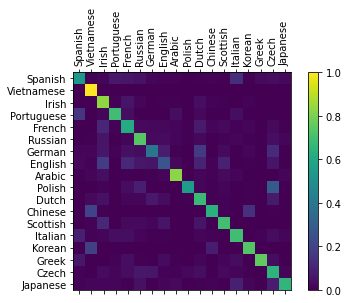

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [41]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Moon')
predict('Koo')


> Dovesky
(-0.65) Russian
(-0.80) Czech
(-4.04) English

> Jackson
(-0.09) Scottish
(-3.01) English
(-4.07) Czech

> Satoshi
(-1.00) Japanese
(-1.00) Italian
(-2.41) Greek

> Moon
(-0.28) Korean
(-2.57) Scottish
(-2.67) Chinese

> Koo
(-0.31) Korean
(-1.75) Chinese
(-3.11) Vietnamese
